# Predicción

Este notebook se divide en tres partes, la creaccion del dataset de prediccion, la prediccion y el post-procesamiento

## 3- Creación de dataset prediccion

#### Variables para configuracion de satproc

In [1]:
size = 600              # tamaño (en pixeles) de las imagenes que se van a generar
step_size = size        # en la predicción no hace falta generar solapamiento, usamos mismo tamaño en step_size

images_path = "/app/data/predict/images/*.tif"        # ruta a las imagenes satelitales
output_dir = f"/app/data/tmp/chips/predict_{size}"    # ruta donde se van a dejar las imagenes porcesadas

**Generación del dataset para predecir**

Creo dataset para prediccion (solo imagenes)

In [2]:
!satproc_extract_chips $images_path \
    -o $output_dir \
    --size $size \
    --step-size $step_size \
    --rescale \
    --rescale-mode percentiles --lower-cut 2 --upper-cut 98

Rasters: 100%|####################################| 1/1 [00:01<00:00,  1.23s/it]


## 4- Predicción

Para efectuar la predicción importamos las funciones necesarias de la libreria *unetseg*

In [3]:
from unetseg.predict import PredictConfig, predict
from unetseg.evaluate import plot_data_results
import os

**Variables para configuracion de la predicción**

In [4]:
images_path = output_dir                          # usamos los chips generados recientemente con satproc
model_path = "/app/data/models/model_sample.h5"        # ruta al modelo que generams en el notebook de entrenamiento
results_path = f"/app/data/tmp/result_chips/{size}"    # ruta a los chips de resultado de predicción

predict_config = PredictConfig(
    images_path=output_dir,
    results_path=results_path,
    batch_size=16,
    model_path=model_path,
    height=160,
    width=160,
    n_channels=3,
    n_classes=1,
    class_weights=[1]
)

Ejecuta la predicción

In [5]:
predict(predict_config)

Total images to predict (/app/data/tmp/chips/predict_600/images/*.tif): 30
After skipping existing results: 30


100%|██████████| 2/2 [00:07<00:00,  3.57s/it]

Done!


Con `plot_data_results` podemos graficar algunos resultados a la par de la imagen de entrada. El chip de resultado es una imagen de un solo canal, con valores entre 0 y 255, donde 0 representa 0% probabilidad de que el pixel pertenezca al objeto de interés, y 255 representa el 100% de que lo sea.  Visualmente, los colores mas brillantes representan areas de posible asentamiento informal.

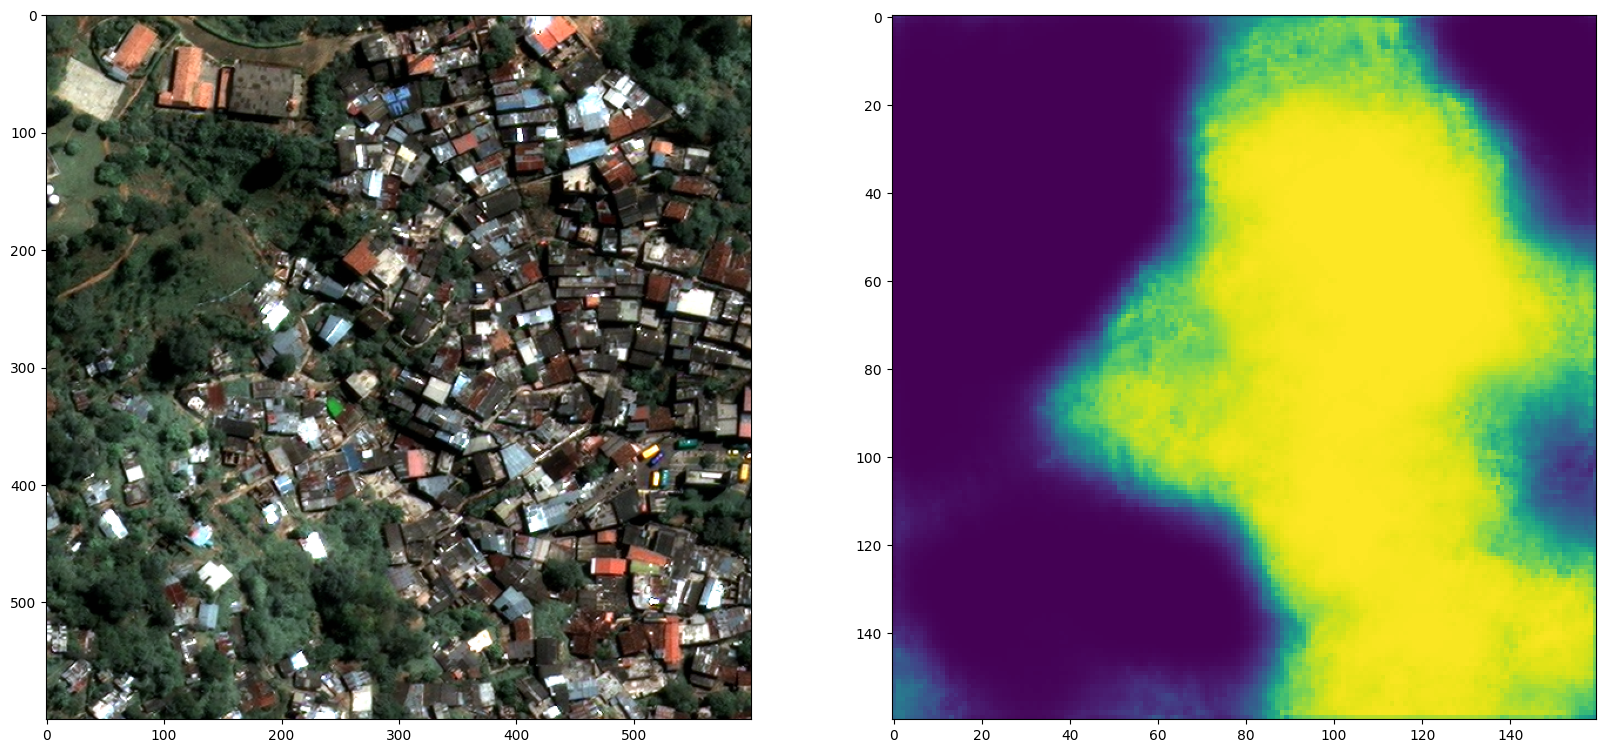

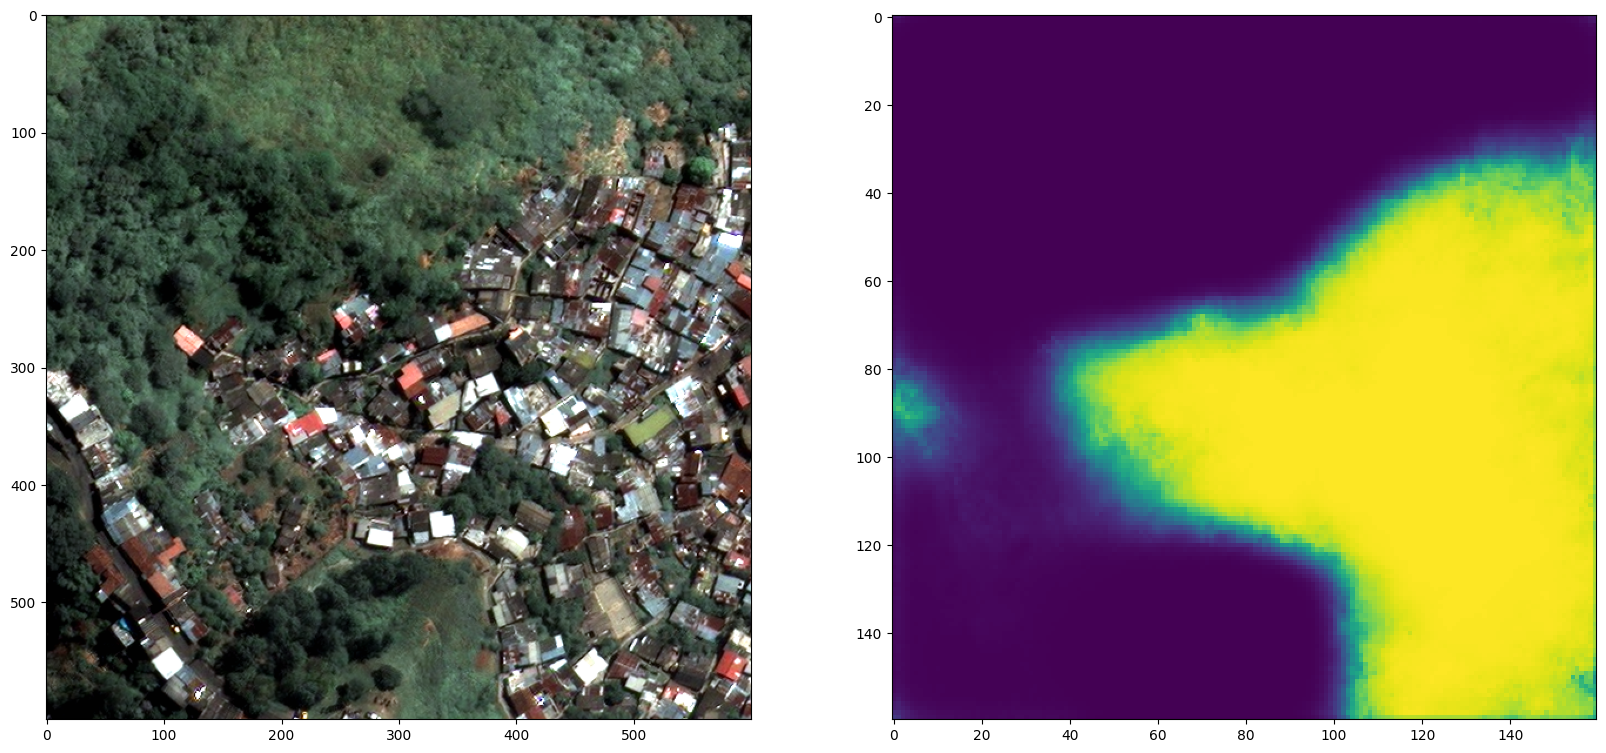

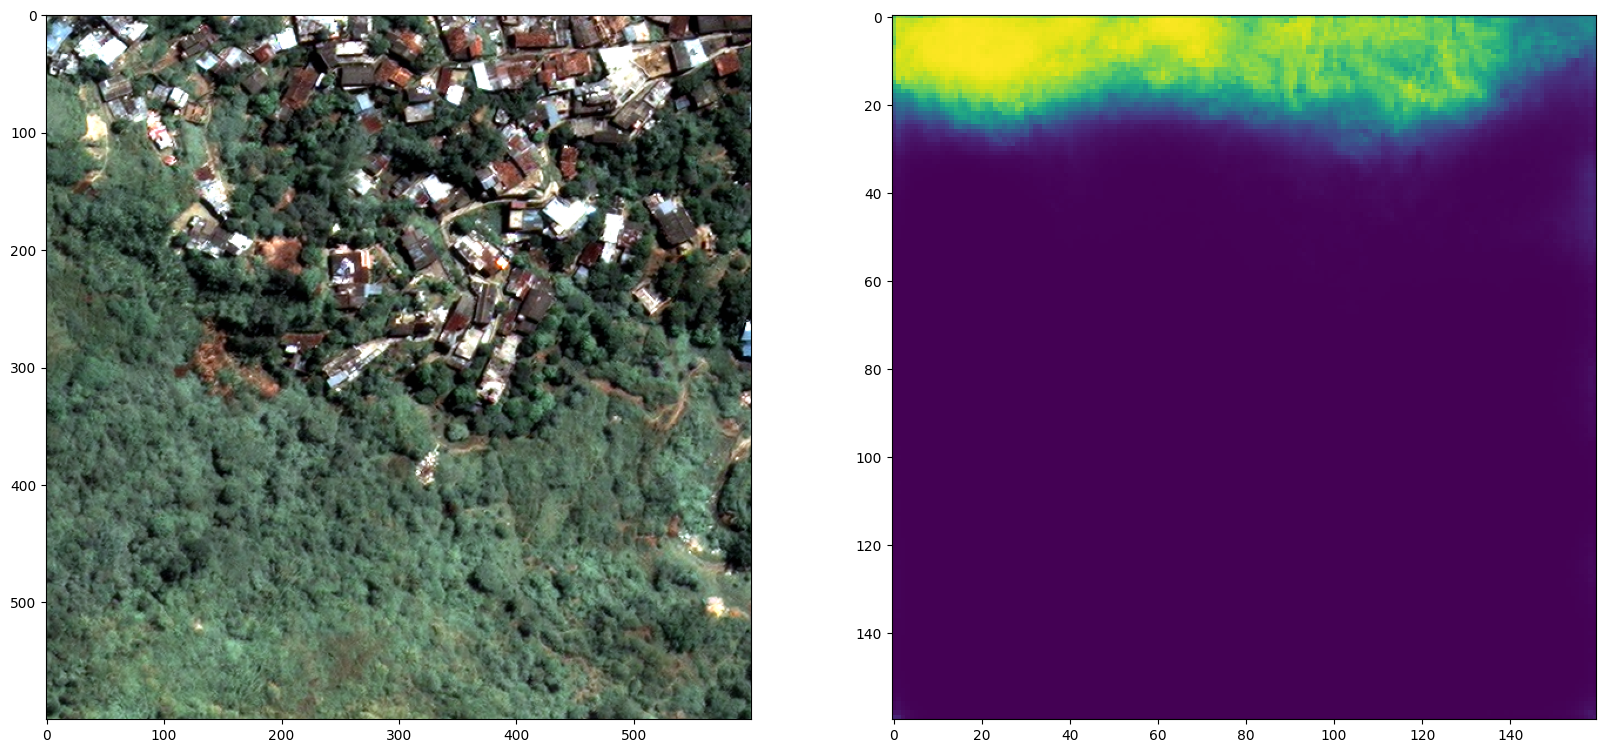

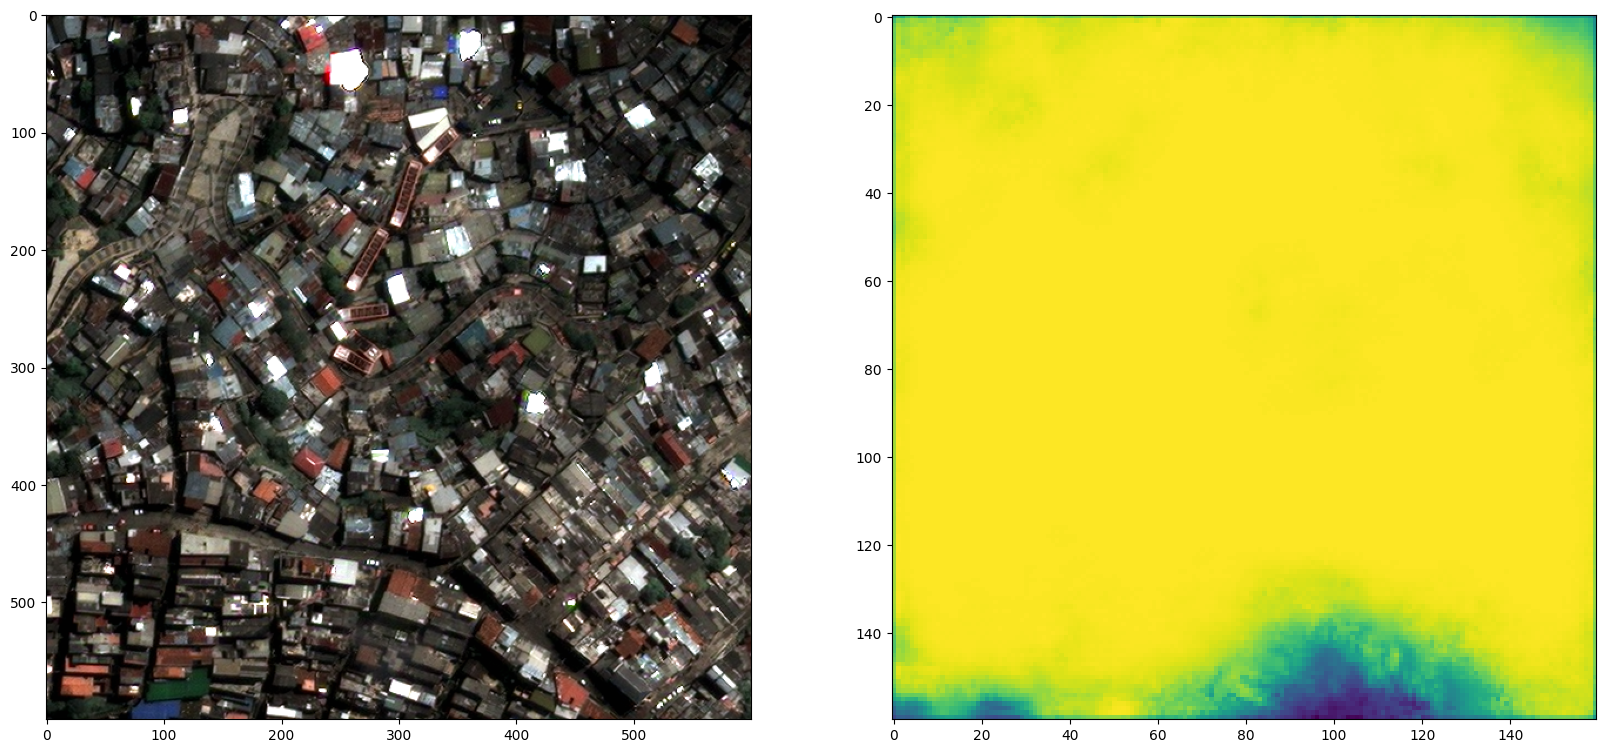

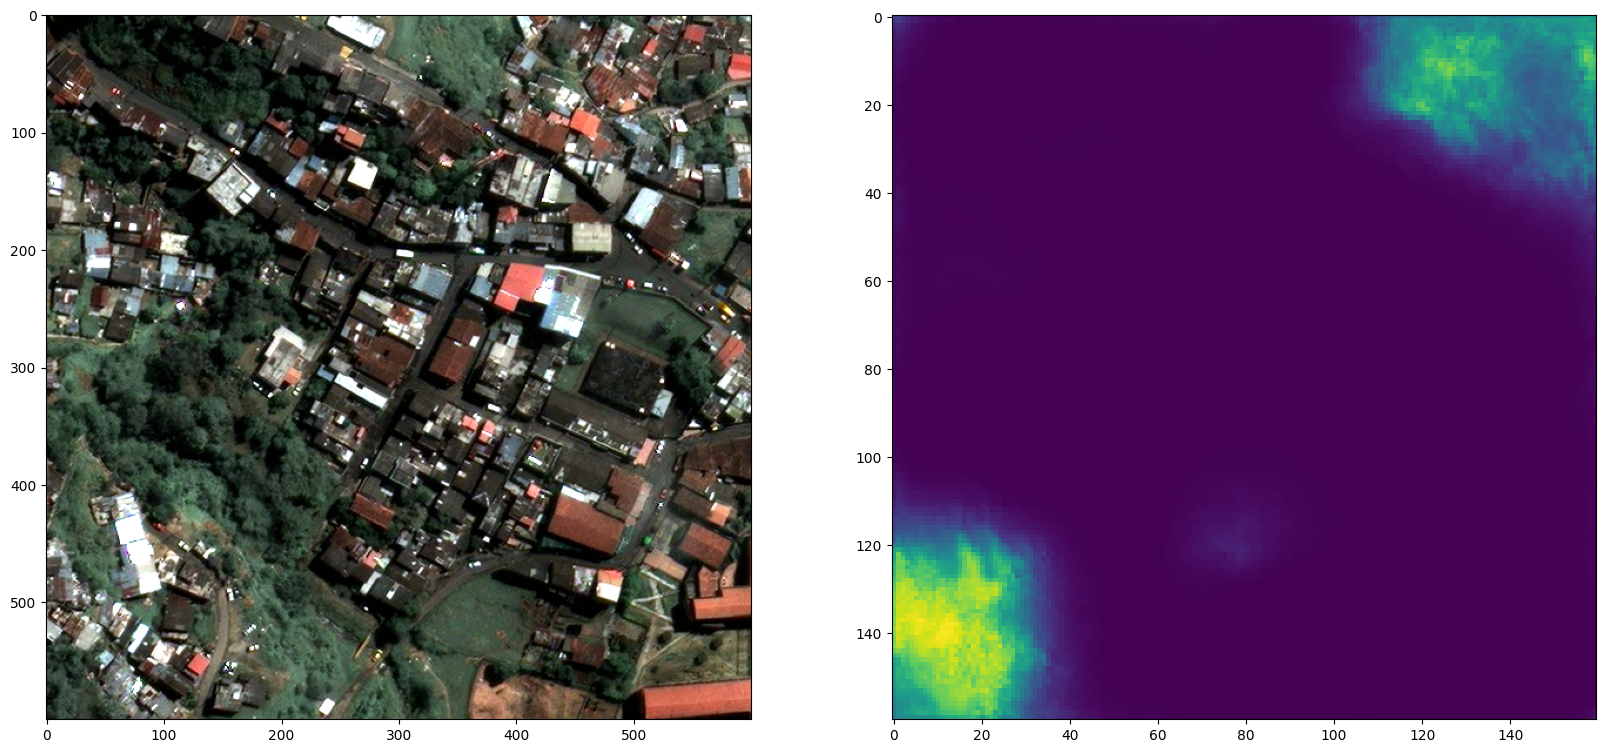

In [13]:
plot_data_results(num_samples=5, fig_size=(5, 5), predict_config=predict_config, img_ch=2, n_bands=3)

## 5- Post-procesamiento

El objetivo de esta etapa es filtrar los resultados para quedarnos con las predicciones más precisas y filtrar aquellas ruidosas 

In [14]:
from satproc.postprocess.polygonize import polygonize 
from satproc.filter import filter_by_max_prob
from maiia.postprocess import filter_by_min_area

### Filtramos las predicciones con probabilidad mayor al parametro y poligonos mayor a una superficie determinada

In [15]:
threshold = 0.5    # parametro a filtrar (probar ≠ prob umbrales, quizas empezar con 0.1)
min_area = 500     # superficie minima a fitrar
output_path = "/app/data/results/results_sample.gpkg"   # ruta al geopackage final de poligonos

In [16]:
# Filtra todos los chips que tengan menor probabilidad a la especificada (threshold)
# y los guarda en otra carpeta (filt_dir)
filt_dir = "/app/data/tmp/filt/"
filter_by_max_prob(
    input_dir=results_path,
    output_dir=filt_dir,
    threshold=threshold
)

100%|##########| 30/30 [00:00<00:00, 158.82it/s]


In [17]:
# Poligoniza todos los chips filtrados en un solo archivo vectorial en formato GeoPackage
poly_path = "/app/data/tmp/poly.gpkg"
polygonize(
    input_dir=filt_dir,
    output=poly_path,
    threshold=threshold,
)

Dissolve: 100%|##########| 22/22 [00:12<00:00,  1.77it/s]


In [18]:
# Filtra poligonos con área mínima (>= min_area)
filter_by_min_area(
    poly_path,
    output_path,
    min_area=min_area
)

Using projected CRS epsg:32618 for filtering by meters


Filtering polygons by area (>=500m): 100%|##########| 91/91 [00:01<00:00, 62.79it/s]


In [19]:
print('Resultados almacenados en:', output_path)

Resultados almacenados en: /app/data/results/results_sample.gpkg
